## Reinforcement Learning Project: Highway-Env

Dieses Projekt ist entstanden in Anlehnung an die Implementierung von [Edouard Leurent](https://github.com/Farama-Foundation/HighwayEnv/blob/master/scripts/sb3_highway_dqn.ipynb), sowie [SAKSHAY MAHNA](https://www.kaggle.com/code/sakshaymahna/highway-dqn/notebook).


In [1]:
!apt install -y ffmpeg

Der Befehl "apt" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [4]:
!pip install rich pyvirtualdisplay


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: C:\Users\Tobia\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


### 1. Import of Libraries

In [47]:
# vollständiger Import
import highway_env

# Alias Import
import gymnasium as gym
import pandas as pd

# Spezifischer Import
from IPython import display
from matplotlib import pyplot as plt, animation
from pathlib import Path
from pyvirtualdisplay import Display
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback

In [2]:
%matplotlib inline

In [3]:
%load_ext tensorboard

### 2. Definition of Constants and Paths
#### a) Constants

In [4]:
# Umgebung
ENVIRONMENT_NAME: str = "highway-v0"
ENVIRONMENT_RENDER_MODE: str = "rgb_array"

In [5]:
# Modelle
BASE_MODEL_POLICY: str = "MlpPolicy"
BASE_MODEL_LIB: str = "stable_baselines3"
DQN_MODEL_TYPE: str = "dqn"
PPO_MODEL_TYPE: str = "ppo"

DQN_MODEL_VERSION: str = "v3"
PPO_MODEL_VERSION: str = "v1"

In [6]:
# Training
TOTAL_TRAINING_STEPS: int = 30000
SAVE_MODEL_FREQUENZ: int = 3000
EVAL_MODEL_FREQUENZ: int = 1500

#### b) Paths

In [31]:
# Definition von allgemeinen Pfaden
CURRENT_FILE_DIR_PATH = Path().absolute()
REPOSITORY_PATH = CURRENT_FILE_DIR_PATH.parent.absolute()
LOG_BASE_PATH = REPOSITORY_PATH.joinpath("logs", BASE_MODEL_LIB)
VIDEOS_BASE_PATH = REPOSITORY_PATH.joinpath("videos", BASE_MODEL_LIB)
MODELS_BASE_PATH = REPOSITORY_PATH.joinpath("highway_models")

In [32]:
# DQN
LOG_DQN_PATH = LOG_BASE_PATH.joinpath(DQN_MODEL_TYPE)
VIDEOS_DQN_PATH = VIDEOS_BASE_PATH.joinpath(DQN_MODEL_TYPE)
MODELS_DQN_PATH = MODELS_BASE_PATH.joinpath(DQN_MODEL_TYPE, BASE_MODEL_LIB, DQN_MODEL_VERSION)

In [33]:
# PPO
LOG_PPO_PATH = LOG_BASE_PATH.joinpath(PPO_MODEL_TYPE)
VIDEOS_PPO_PATH = VIDEOS_BASE_PATH.joinpath(PPO_MODEL_TYPE)
MODELS_PPO_PATH = MODELS_BASE_PATH.joinpath(PPO_MODEL_TYPE, BASE_MODEL_LIB, PPO_MODEL_VERSION)

### 2. Definition of Objects and Functions
#### a) Objects

In [10]:
# Kombinierung der Modellinformationen
LIST_MODEL_TYPE: [str] = [DQN_MODEL_TYPE, PPO_MODEL_TYPE]
LIST_MODEL_VERSION: [str] = [DQN_MODEL_VERSION, PPO_MODEL_VERSION]

In [11]:
# Kombinierung der Pfade
LIST_LOG_PATH: [str] = [LOG_DQN_PATH, LOG_PPO_PATH]
LIST_VIDEOS_PATH: [str] = [VIDEOS_DQN_PATH, VIDEOS_PPO_PATH]
LIST_MODEL_PATH: [str] = [MODELS_DQN_PATH, MODELS_PPO_PATH]

In [29]:
list_of_steps: list = ['best'] + [str(i) for i in
                                  range(SAVE_MODEL_FREQUENZ, TOTAL_TRAINING_STEPS, SAVE_MODEL_FREQUENZ)] + [
                          str(TOTAL_TRAINING_STEPS)]

#### b) Functions

In [39]:
def prepare_env(
        gymnasium_env: gym.Env,
        log_dir_path: Path,
        print_info: bool = False) -> gym.Env:
    """
    Funktion zum Vorbereiten der Gymnasiumsumgebungen für das Training mit StableBaselines3 (unabhängig vom Agenten)
    :param gymnasium_env: Umgebung welche verwendet werden soll
    :param log_dir_path: Pfad, auf welchen die Logs gespeichert werden sollen
    :param print_info: Boolean, welcher aussagt, ob die Information ausgegeben werden soll
    :return: vorbereitete Umgebung
    """
    # Verpacken Sie die Umgebung mit einem Monitor-Wrapper
    env = Monitor(gymnasium_env, str(log_dir_path))

    # Vektorisieren Sie die Umgebung (notwendig für Stable Baselines3)
    env = DummyVecEnv([lambda: env])
    if not print_info:
        return env
    else:
        print(f'<Info> : Log will be written to the following dir {log_dir_path.absolute()}')

In [13]:
def train_multi_agents(
        base_policy: str,
        environment: gym.Env,
        eval_env: gym.Env,
        model_list: list[str],
        log_list: list[Path],
        save_path_list: list[Path],
        total_timestep: int,
        save_freq: int,
        eval_freq: int,
        log_info: bool,
        verbose: int = 1,
        process_bar: bool = True
):
    """

    :param base_policy:
    :param environment:
    :param eval_env:
    :param model_list:
    :param log_list:
    :param save_path_list:
    :param total_timestep:
    :param save_freq:
    :param eval_freq:
    :param log_info:
    :param verbose:
    :param process_bar:
    :return:
    """
    # Definitionen von Hilfsobjekte
    model = None
    trained_model: list = []
    for model_type, log_path, save_path in zip(model_list, log_list, save_path_list):
        # Vorbereiten der Umgebung
        env = prepare_env(
            gymnasium_env=environment,
            log_dir_path=log_path,
            print_info=log_info
        )

        # Erstellung des Modells
        if model_type == 'dqn':
            model = DQN(
                policy=base_policy,
                env=env,
                verbose=verbose,
                tensorboard_log=log_path
            )
        elif model_type == 'ppo':
            model = PPO(
                policy=base_policy,
                env=env,
                verbose=verbose,
                tensorboard_log=log_path
            )
        else:
            raise Exception("Undefinierter Modell-Type")

        # Erstellung der Callbacks:
        checkpoint_callback = CheckpointCallback(
            save_freq=save_freq,
            save_path=save_path,
            name_prefix=f'model_{model_type}')

        # Erstellen Sie eine EvalCallback
        eval_callback = EvalCallback(
            eval_env,
            best_model_save_path=save_path,
            log_path=log_path,
            eval_freq=eval_freq)

        # Verbindung der Callbacks
        callbacks = [checkpoint_callback, eval_callback]

        # trainiere das Modell
        model.learn(
            total_timesteps=total_timestep,
            callback=callbacks,
            progress_bar=process_bar
        )
        trained_model.append(model)
        model = None
    return trained_model

In [54]:
def record_env(env: gym.Env, model, video_output_folder: Path, training: str):
    """
    Erstellt ein Video der Umgebung.
    :param env: Umgebung, die aufgezeichnet werden soll.
    :param model: Modell, das die Aktionen vorgibt.
    :param video_output_folder: Pfad, in dem das Video gespeichert werden soll.
    :param training: Anzahl der Trainingsschritte.
    :return:
    """
    # Pfad erstellen
    new_path = video_output_folder.joinpath(f'timesteps_{training}')

    # Vorbereiten der Umgebung
    env = DummyVecEnv([lambda: env])
    # Erstellen des Video-Recorders
    wrapped_env = VecVideoRecorder(
        env,
        video_folder=str(new_path),
        record_video_trigger=lambda step: step % 10000 == 0)

    for episode in range(3):
        obs = wrapped_env.reset()
        done = truncated = False
        while not (done or truncated):
            action = model.predict(obs, deterministic=True)[0]
            obs, reward, done, truncated = wrapped_env.step(action)
    wrapped_env.close()

In [12]:
def load_models_from_dir(
        path: Path,
        model_type: str,
        doc_extension: str = '.zip'
) -> list:
    """
    Funktion zum Laden von Modellen aus einem Ordner
    :param path: Pfad, in dem die Modelle gespeichert sind
    :param model_type: Typ des Modells (dqn, ppo)
    :param doc_extension: Dateiendung der Modelle
    :return: Liste mit den geladenen Modellen
    """
    # Erstellen einer leeren Liste
    model_list: list = []
    # Estelle eine Liste mit Pfaden zu den Modellen
    model_path_list: list = list(path.glob("*.zip"))

    # Iteration über alle Dateien im Ordner
    for model_path in model_path_list:
        # Überprüfe, ob es sich um ein DQN handelt
        if model_type == 'dqn':
            try:
                # Laden des Modells
                model = DQN.load(model_path)
                model_list.append(model)
            except:
                raise Exception(f"Fehler beim Laden des Modells: {model_path}")
        # Überprüfe, ob es sich um ein PPO handelt
        elif model_type == 'ppo':
            try:
                # Laden des Modells
                model = PPO.load(model_path)
                model_list.append(model)
            except:
                raise Exception(f"Fehler beim Laden des Modells: {model_path}")
        else:
            raise Exception("Undefinierter Modell-Type")
    return model_list

### 3. Definition der Umgebungen
#### a) Trainingsumgebung

In [14]:
# Definition der Trainingsumgebung
train_env = gym.make(ENVIRONMENT_NAME)

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


#### b) Evaluierungsumgebung

In [15]:
# Definition der Evaluierungsumgebung
eval_env = gym.make(ENVIRONMENT_NAME)

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


#### c) Visualisationsumgebung

In [15]:
# Definition der Visualisationsumgebung
vis_env = gym.make(ENVIRONMENT_NAME, render_mode=ENVIRONMENT_RENDER_MODE)

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


### 4. Definition von Callbacks
#### a) Checkpoints (Beispiel - DQN)

In [27]:
checkpoint_callback_dqn = CheckpointCallback(
    save_freq=SAVE_MODEL_FREQUENZ,
    save_path=MODELS_DQN_PATH,
    name_prefix="dqn_model")

#### b) Evaluation (Beispiel - DQN)

In [28]:
eval_callback_dqn = EvalCallback(
    eval_env,
    best_model_save_path=MODELS_DQN_PATH,
    log_path=LOG_DQN_PATH,
    eval_freq=EVAL_MODEL_FREQUENZ)

#### c) Checkpoints (Beispiel - PPO)

In [29]:
checkpoint_callback_ppo = CheckpointCallback(
    save_freq=SAVE_MODEL_FREQUENZ,
    save_path=MODELS_PPO_PATH,
    name_prefix="ppo_model")

#### d) Evaluation (Beispiel - PPO)

In [30]:
eval_callback_ppo = EvalCallback(
    eval_env,
    best_model_save_path=MODELS_PPO_PATH,
    log_path=LOG_PPO_PATH,
    eval_freq=EVAL_MODEL_FREQUENZ)

### 5. Training von Modellen
#### a) DQN - Beispiel

In [31]:
# Erstellen Sie das Modell
model_dqn = DQN(
    BASE_MODEL_POLICY,
    prepare_env(
        gymnasium_env=train_env,
        log_dir_path=LOG_DQN_PATH
    ),
    verbose=1,
    tensorboard_log=LOG_DQN_PATH)

Using cuda device


In [32]:
# Trainieren Sie das Modell
model_dqn.learn(
    total_timesteps=TOTAL_TRAINING_STEPS,
    callback=[checkpoint_callback_dqn, eval_callback_dqn],
    progress_bar=True)

Logging to /mnt/d/Projects/Hand-on-Reinforced-Learning/logs/stable_baselines3/dqn/DQN_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12       |
|    ep_rew_mean      | 9.4      |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3        |
|    time_elapsed     | 13       |
|    total_timesteps  | 48       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.6     |
|    ep_rew_mean      | 8.37     |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3        |
|    time_elapsed     | 24       |
|    total_timesteps  | 85       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.3     |
|    ep_rew_mean      | 7.98     |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes       

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=1500, episode_reward=5.93 +/- 3.64

Episode length: 7.00 +/- 3.79

----------------------------------
| eval/               |          |
|    mean_ep_length   | 7        |
|    mean_reward      | 5.93     |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 1500     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.1     |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.522    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 3        |
|    time_elapsed     | 440      |
|    total_timesteps  | 1509     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.3     |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.501    |
| time/               |          |
|    episodes         | 104      |
|    fps              | 3        |
|    time_elapsed     | 460      |
|    total_timesteps  | 1576     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.4     |
|    ep_rew_mean      | 11.7     |
|    exploration_rate | 0.484    |
| time/               |          |
|    episodes       

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=3000, episode_reward=10.76 +/- 2.80

Episode length: 12.00 +/- 2.97

----------------------------------
| eval/               |          |
|    mean_ep_length   | 12       |
|    mean_reward      | 10.8     |
| rollout/            |          |
|    exploration_rate | 0.0503   |
| time/               |          |
|    total_timesteps  | 3000     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.3     |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 204      |
|    fps              | 3        |
|    time_elapsed     | 888      |
|    total_timesteps  | 3005     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.3     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 208      |
|    fps              | 3        |
|    time_elapsed     | 903      |
|    total_timesteps  | 3056     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.1     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=4500, episode_reward=10.39 +/- 2.50

Episode length: 11.60 +/- 2.73

----------------------------------
| eval/               |          |
|    mean_ep_length   | 11.6     |
|    mean_reward      | 10.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 4500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.3     |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 312      |
|    fps              | 3        |
|    time_elapsed     | 1344     |
|    total_timesteps  | 4534     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.5     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 316      |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=6000, episode_reward=7.46 +/- 5.79

Episode length: 8.60 +/- 6.15

----------------------------------
| eval/               |          |
|    mean_ep_length   | 8.6      |
|    mean_reward      | 7.46     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 6000     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 9.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 3        |
|    time_elapsed     | 1786     |
|    total_timesteps  | 6025     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.7     |
|    ep_rew_mean      | 9.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 432      |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=7500, episode_reward=9.68 +/- 4.54

Episode length: 10.80 +/- 4.71

----------------------------------
| eval/               |          |
|    mean_ep_length   | 10.8     |
|    mean_reward      | 9.68     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 7500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.6     |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 532      |
|    fps              | 3        |
|    time_elapsed     | 2233     |
|    total_timesteps  | 7524     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.5     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 536      |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=9000, episode_reward=7.61 +/- 5.45

Episode length: 8.60 +/- 5.54

----------------------------------
| eval/               |          |
|    mean_ep_length   | 8.6      |
|    mean_reward      | 7.61     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 9000     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.4     |
|    ep_rew_mean      | 10.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 644      |
|    fps              | 3        |
|    time_elapsed     | 2684     |
|    total_timesteps  | 9048     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.3     |
|    ep_rew_mean      | 9.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 648      |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=10500, episode_reward=10.23 +/- 6.38

Episode length: 11.60 +/- 6.56

----------------------------------
| eval/               |          |
|    mean_ep_length   | 11.6     |
|    mean_reward      | 10.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 10500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.5     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 744      |
|    fps              | 3        |
|    time_elapsed     | 3120     |
|    total_timesteps  | 10502    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.1     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 748      |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=12000, episode_reward=5.65 +/- 3.19

Episode length: 6.80 +/- 3.31

----------------------------------
| eval/               |          |
|    mean_ep_length   | 6.8      |
|    mean_reward      | 5.65     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 12000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.9     |
|    ep_rew_mean      | 10.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 852      |
|    fps              | 3        |
|    time_elapsed     | 3570     |
|    total_timesteps  | 12034    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.8     |
|    ep_rew_mean      | 10.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 856      |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=13500, episode_reward=6.25 +/- 4.78

Episode length: 7.20 +/- 4.79

----------------------------------
| eval/               |          |
|    mean_ep_length   | 7.2      |
|    mean_reward      | 6.25     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 13500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15       |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 952      |
|    fps              | 3        |
|    time_elapsed     | 4010     |
|    total_timesteps  | 13535    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.2     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 956      |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=15000, episode_reward=6.86 +/- 3.30

Episode length: 8.00 +/- 3.35

----------------------------------
| eval/               |          |
|    mean_ep_length   | 8        |
|    mean_reward      | 6.86     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 15000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14       |
|    ep_rew_mean      | 10.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1056     |
|    fps              | 3        |
|    time_elapsed     | 4442     |
|    total_timesteps  | 15000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.3     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1060     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=16500, episode_reward=7.16 +/- 4.76

Episode length: 8.20 +/- 4.79

----------------------------------
| eval/               |          |
|    mean_ep_length   | 8.2      |
|    mean_reward      | 7.16     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 16500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.3     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1156     |
|    fps              | 3        |
|    time_elapsed     | 4894     |
|    total_timesteps  | 16535    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.5     |
|    ep_rew_mean      | 11.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=18000, episode_reward=7.43 +/- 5.63

Episode length: 8.80 +/- 6.05

----------------------------------
| eval/               |          |
|    mean_ep_length   | 8.8      |
|    mean_reward      | 7.43     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 18000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.3     |
|    ep_rew_mean      | 12.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1248     |
|    fps              | 3        |
|    time_elapsed     | 5343     |
|    total_timesteps  | 18059    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.6     |
|    ep_rew_mean      | 12.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1252     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=19500, episode_reward=5.43 +/- 1.87

Episode length: 6.60 +/- 1.85

----------------------------------
| eval/               |          |
|    mean_ep_length   | 6.6      |
|    mean_reward      | 5.43     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 19500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.1     |
|    ep_rew_mean      | 13.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1328     |
|    fps              | 3        |
|    time_elapsed     | 5777     |
|    total_timesteps  | 19542    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.5     |
|    ep_rew_mean      | 14.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1332     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=21000, episode_reward=7.26 +/- 5.52

Episode length: 8.60 +/- 5.78

----------------------------------
| eval/               |          |
|    mean_ep_length   | 8.6      |
|    mean_reward      | 7.26     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 21000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.6     |
|    ep_rew_mean      | 10.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1436     |
|    fps              | 3        |
|    time_elapsed     | 6214     |
|    total_timesteps  | 21017    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.1     |
|    ep_rew_mean      | 9.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1440     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=22500, episode_reward=5.22 +/- 1.17

Episode length: 6.40 +/- 1.36

----------------------------------
| eval/               |          |
|    mean_ep_length   | 6.4      |
|    mean_reward      | 5.22     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 22500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.9     |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 3        |
|    time_elapsed     | 6664     |
|    total_timesteps  | 22553    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.3     |
|    ep_rew_mean      | 11.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=24000, episode_reward=6.72 +/- 4.33

Episode length: 7.80 +/- 4.40

----------------------------------
| eval/               |          |
|    mean_ep_length   | 7.8      |
|    mean_reward      | 6.72     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 24000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.7     |
|    ep_rew_mean      | 10.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1644     |
|    fps              | 3        |
|    time_elapsed     | 7096     |
|    total_timesteps  | 24015    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.2     |
|    ep_rew_mean      | 9.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1648     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=25500, episode_reward=11.45 +/- 6.58

Episode length: 12.80 +/- 6.85

----------------------------------
| eval/               |          |
|    mean_ep_length   | 12.8     |
|    mean_reward      | 11.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25500    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.7     |
|    ep_rew_mean      | 10.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1752     |
|    fps              | 3        |
|    time_elapsed     | 7545     |
|    total_timesteps  | 25519    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.2     |
|    ep_rew_mean      | 10       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1756     |
|    fps              | 3        |
|    time_elapsed     | 7558     |
|    total_timesteps  | 25565    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.4     |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=27000, episode_reward=10.22 +/- 6.51

Episode length: 11.80 +/- 6.79

----------------------------------
| eval/               |          |
|    mean_ep_length   | 11.8     |
|    mean_reward      | 10.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 27000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.5     |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1856     |
|    fps              | 3        |
|    time_elapsed     | 7991     |
|    total_timesteps  | 27014    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.2     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=28500, episode_reward=6.68 +/- 5.43

Episode length: 7.80 +/- 5.71

----------------------------------
| eval/               |          |
|    mean_ep_length   | 7.8      |
|    mean_reward      | 6.68     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 28500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.3     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1964     |
|    fps              | 3        |
|    time_elapsed     | 8438     |
|    total_timesteps  | 28527    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.6     |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1968     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=30000, episode_reward=5.74 +/- 3.67

Episode length: 7.00 +/- 3.79

----------------------------------
| eval/               |          |
|    mean_ep_length   | 7        |
|    mean_reward      | 5.74     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
----------------------------------


#### b) PPO - Beispiel

In [33]:
# Erstellen Sie das Modell
model_ppo = PPO(
    BASE_MODEL_POLICY,
    prepare_env(
        gymnasium_env=train_env,
        log_dir_path=LOG_PPO_PATH
    ),
    verbose=1,
    tensorboard_log=LOG_PPO_PATH)

Using cuda device


In [34]:
# Trainieren Sie das Modell
model_ppo.learn(
    total_timesteps=TOTAL_TRAINING_STEPS,
    callback=[checkpoint_callback_ppo, eval_callback_ppo],
    progress_bar=True)

Logging to /mnt/d/Projects/Hand-on-Reinforced-Learning/logs/stable_baselines3/ppo/PPO_2


Output()

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=1500, episode_reward=10.10 +/- 6.19

Episode length: 13.60 +/- 7.74

---------------------------------
| eval/              |          |
|    mean_ep_length  | 13.6     |
|    mean_reward     | 10.1     |
| time/              |          |
|    total_timesteps | 1500     |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.8     |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    fps             | 3        |
|    iterations      | 1        |
|    time_elapsed    | 615      |
|    total_timesteps | 2048     |
---------------------------------


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=3000, episode_reward=23.26 +/- 9.53

Episode length: 33.20 +/- 13.60

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 33.2        |
|    mean_reward          | 23.3        |
| time/                   |             |
|    total_timesteps      | 3000        |
| train/                  |             |
|    approx_kl            | 0.014973334 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | -0.0114     |
|    learning_rate        | 0.0003      |
|    loss                 | 4.98        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0188     |
|    value_loss           | 14.5        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | 13.4     |
| time/              |          |
|    fps             | 3        |
|    iterations      | 2        |
|    time_elapsed    | 1258     |
|    total_timesteps | 4096     |
---------------------------------


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=4500, episode_reward=28.12 +/- 0.91

Episode length: 40.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 40          |
|    mean_reward          | 28.1        |
| time/                   |             |
|    total_timesteps      | 4500        |
| train/                  |             |
|    approx_kl            | 0.012969919 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.0376      |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 23.8        |
-----------------------------------------


New best mean reward!

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=6000, episode_reward=28.12 +/- 0.91

Episode length: 40.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 40       |
|    mean_reward     | 28.1     |
| time/              |          |
|    total_timesteps | 6000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.7     |
|    ep_rew_mean     | 16.8     |
| time/              |          |
|    fps             | 3        |
|    iterations      | 3        |
|    time_elapsed    | 1966     |
|    total_timesteps | 6144     |
---------------------------------


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=7500, episode_reward=27.94 +/- 0.71

Episode length: 40.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 40          |
|    mean_reward          | 27.9        |
| time/                   |             |
|    total_timesteps      | 7500        |
| train/                  |             |
|    approx_kl            | 0.011074713 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.115       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.4        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0144     |
|    value_loss           | 27.1        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23       |
|    ep_rew_mean     | 16.8     |
| time/              |          |
|    fps             | 3        |
|    iterations      | 4        |
|    t

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=9000, episode_reward=27.58 +/- 1.12

Episode length: 40.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 40         |
|    mean_reward          | 27.6       |
| time/                   |            |
|    total_timesteps      | 9000       |
| train/                  |            |
|    approx_kl            | 0.01409276 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.45      |
|    explained_variance   | 0.144      |
|    learning_rate        | 0.0003     |
|    loss                 | 16.1       |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.0194    |
|    value_loss           | 36.5       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.7     |
|    ep_rew_mean     | 20       |
| time/              |          |
|    fps             | 3        |
|    iterations      | 5        |
|    time_elapsed    | 3

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=10500, episode_reward=27.41 +/- 1.04

Episode length: 40.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 40          |
|    mean_reward          | 27.4        |
| time/                   |             |
|    total_timesteps      | 10500       |
| train/                  |             |
|    approx_kl            | 0.013280699 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.139       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.7        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 34.6        |
-----------------------------------------


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=12000, episode_reward=26.87 +/- 0.36

Episode length: 40.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 40       |
|    mean_reward     | 26.9     |
| time/              |          |
|    total_timesteps | 12000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.9     |
|    ep_rew_mean     | 23.6     |
| time/              |          |
|    fps             | 3        |
|    iterations      | 6        |
|    time_elapsed    | 3980     |
|    total_timesteps | 12288    |
---------------------------------


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=13500, episode_reward=27.76 +/- 1.31

Episode length: 40.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 40          |
|    mean_reward          | 27.8        |
| time/                   |             |
|    total_timesteps      | 13500       |
| train/                  |             |
|    approx_kl            | 0.017802373 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.0865      |
|    learning_rate        | 0.0003      |
|    loss                 | 8.79        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0196     |
|    value_loss           | 33.4        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.2     |
|    ep_rew_mean     | 25.2     |
| time/              |          |
|    fps             | 3        |
|    iterations      | 7        |
|    t

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=15000, episode_reward=28.29 +/- 1.04

Episode length: 40.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 40          |
|    mean_reward          | 28.3        |
| time/                   |             |
|    total_timesteps      | 15000       |
| train/                  |             |
|    approx_kl            | 0.014244647 |
|    clip_fraction        | 0.0925      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.121       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.5        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 35.1        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37       |
|    ep_rew_mean     | 26.5     |
| time/              |          |
|    fps             | 3        |
|    iterations      | 8        |
|    time_elapsed    | 5289     |
|    total_timesteps | 16384    |
---------------------------------


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=16500, episode_reward=27.76 +/- 0.67

Episode length: 40.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 40          |
|    mean_reward          | 27.8        |
| time/                   |             |
|    total_timesteps      | 16500       |
| train/                  |             |
|    approx_kl            | 0.004737662 |
|    clip_fraction        | 0.0542      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.993      |
|    explained_variance   | 0.0746      |
|    learning_rate        | 0.0003      |
|    loss                 | 2.56        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00439    |
|    value_loss           | 18.2        |
-----------------------------------------


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=18000, episode_reward=28.47 +/- 0.97

Episode length: 40.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 40       |
|    mean_reward     | 28.5     |
| time/              |          |
|    total_timesteps | 18000    |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.6     |
|    ep_rew_mean     | 26.8     |
| time/              |          |
|    fps             | 3        |
|    iterations      | 9        |
|    time_elapsed    | 6000     |
|    total_timesteps | 18432    |
---------------------------------


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=19500, episode_reward=28.47 +/- 0.80

Episode length: 40.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 40          |
|    mean_reward          | 28.5        |
| time/                   |             |
|    total_timesteps      | 19500       |
| train/                  |             |
|    approx_kl            | 0.009429568 |
|    clip_fraction        | 0.0815      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.908      |
|    explained_variance   | 0.11        |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00639    |
|    value_loss           | 27.9        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.8     |
|    ep_rew_mean     | 26.1     |
| time/              |          |
|    fps             | 3        |
|    iterations      | 10       |
|    t

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=21000, episode_reward=28.29 +/- 0.87

Episode length: 40.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 40          |
|    mean_reward          | 28.3        |
| time/                   |             |
|    total_timesteps      | 21000       |
| train/                  |             |
|    approx_kl            | 0.005455341 |
|    clip_fraction        | 0.0509      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.793      |
|    explained_variance   | 0.0677      |
|    learning_rate        | 0.0003      |
|    loss                 | 8.06        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00379    |
|    value_loss           | 25.5        |
-----------------------------------------


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=22500, episode_reward=27.58 +/- 0.97

Episode length: 40.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 40       |
|    mean_reward     | 27.6     |
| time/              |          |
|    total_timesteps | 22500    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38       |
|    ep_rew_mean     | 26.8     |
| time/              |          |
|    fps             | 3        |
|    iterations      | 11       |
|    time_elapsed    | 7363     |
|    total_timesteps | 22528    |
---------------------------------


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=24000, episode_reward=27.41 +/- 0.87

Episode length: 40.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 40           |
|    mean_reward          | 27.4         |
| time/                   |              |
|    total_timesteps      | 24000        |
| train/                  |              |
|    approx_kl            | 0.0049764565 |
|    clip_fraction        | 0.0352       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.727       |
|    explained_variance   | 0.136        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.987        |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00123     |
|    value_loss           | 9.08         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.9     |
|    ep_rew_mean     | 27.3     |
| time/              |          |
|    fps             | 3        |
|    iterations      |

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=25500, episode_reward=26.16 +/- 3.84

Episode length: 37.80 +/- 4.40

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 37.8         |
|    mean_reward          | 26.2         |
| time/                   |              |
|    total_timesteps      | 25500        |
| train/                  |              |
|    approx_kl            | 0.0040619737 |
|    clip_fraction        | 0.0304       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.728       |
|    explained_variance   | 0.0767       |
|    learning_rate        | 0.0003       |
|    loss                 | 13.5         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00141     |
|    value_loss           | 11.2         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.6     |
|    ep_rew_mean     | 27.2     |
| time/              |          |
|    fps             | 3        |
|    iterations      |

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=27000, episode_reward=28.12 +/- 1.07

Episode length: 40.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 40           |
|    mean_reward          | 28.1         |
| time/                   |              |
|    total_timesteps      | 27000        |
| train/                  |              |
|    approx_kl            | 0.0012779178 |
|    clip_fraction        | 0.033        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.692       |
|    explained_variance   | -0.0177      |
|    learning_rate        | 0.0003       |
|    loss                 | 4.79         |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.000359    |
|    value_loss           | 30.6         |
------------------------------------------


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=28500, episode_reward=27.58 +/- 0.97

Episode length: 40.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 40       |
|    mean_reward     | 27.6     |
| time/              |          |
|    total_timesteps | 28500    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.2     |
|    ep_rew_mean     | 27       |
| time/              |          |
|    fps             | 3        |
|    iterations      | 14       |
|    time_elapsed    | 9369     |
|    total_timesteps | 28672    |
---------------------------------


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=30000, episode_reward=27.94 +/- 1.21

Episode length: 40.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 40           |
|    mean_reward          | 27.9         |
| time/                   |              |
|    total_timesteps      | 30000        |
| train/                  |              |
|    approx_kl            | 0.0013297662 |
|    clip_fraction        | 0.0166       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.683       |
|    explained_variance   | 0.0518       |
|    learning_rate        | 0.0003       |
|    loss                 | 6.52         |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00133     |
|    value_loss           | 33.5         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.4     |
|    ep_rew_mean     | 27.1     |
| time/              |          |
|    fps             | 3        |
|    iterations      |

#### c) Trainiere Multi-Agenten

In [ ]:
trained_agents = train_multi_agents(
    base_policy=BASE_MODEL_POLICY,
    environment=train_env,
    eval_env=eval_env,
    model_list=LIST_MODEL_TYPE,
    log_list=LIST_LOG_PATH,
    save_path_list=LIST_MODEL_PATH,
    total_timestep=TOTAL_TRAINING_STEPS,
    eval_freq=EVAL_MODEL_FREQUENZ,
    save_freq=SAVE_MODEL_FREQUENZ,
    log_info=False
)

Using cuda device
Logging to /mnt/d/Projects/Hand-on-Reinforced-Learning/logs/stable_baselines3/dqn/DQN_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.5     |
|    ep_rew_mean      | 14.5     |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3        |
|    time_elapsed     | 22       |
|    total_timesteps  | 74       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.9     |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3        |
|    time_elapsed     | 35       |
|    total_timesteps  | 119      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.7     |
|    ep_rew_mean      | 10.5     |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes       

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=1500, episode_reward=8.45 +/- 7.07

Episode length: 9.80 +/- 7.19

----------------------------------
| eval/               |          |
|    mean_ep_length   | 9.8      |
|    mean_reward      | 8.45     |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 1500     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.9     |
|    ep_rew_mean      | 9.65     |
|    exploration_rate | 0.52     |
| time/               |          |
|    episodes         | 116      |
|    fps              | 3        |
|    time_elapsed     | 464      |
|    total_timesteps  | 1517     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.9     |
|    ep_rew_mean      | 9.7      |
|    exploration_rate | 0.499    |
| time/               |          |
|    episodes         | 120      |
|    fps              | 3        |
|    time_elapsed     | 487      |
|    total_timesteps  | 1582     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.1     |
|    ep_rew_mean      | 9.84     |
|    exploration_rate | 0.483    |
| time/               |          |
|    episodes       

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=3000, episode_reward=11.45 +/- 5.44

Episode length: 12.80 +/- 5.74

----------------------------------
| eval/               |          |
|    mean_ep_length   | 12.8     |
|    mean_reward      | 11.5     |
| rollout/            |          |
|    exploration_rate | 0.0503   |
| time/               |          |
|    total_timesteps  | 3000     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.3     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 220      |
|    fps              | 3        |
|    time_elapsed     | 920      |
|    total_timesteps  | 3011     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.1     |
|    ep_rew_mean      | 10.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 224      |
|    fps              | 3        |
|    time_elapsed     | 930      |
|    total_timesteps  | 3045     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.7     |
|    ep_rew_mean      | 10.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=4500, episode_reward=7.80 +/- 3.26

Episode length: 9.20 +/- 3.25

----------------------------------
| eval/               |          |
|    mean_ep_length   | 9.2      |
|    mean_reward      | 7.8      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 4500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.2     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 332      |
|    fps              | 3        |
|    time_elapsed     | 1381     |
|    total_timesteps  | 4506     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.2     |
|    ep_rew_mean      | 10.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 336      |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=6000, episode_reward=12.84 +/- 3.41

Episode length: 14.20 +/- 3.60

----------------------------------
| eval/               |          |
|    mean_ep_length   | 14.2     |
|    mean_reward      | 12.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 6000     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14       |
|    ep_rew_mean      | 10.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 440      |
|    fps              | 3        |
|    time_elapsed     | 1869     |
|    total_timesteps  | 6061     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.4     |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 444      |
|    fps              | 3        |
|    time_elapsed     | 1891     |
|    total_timesteps  | 6135     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14       |
|    ep_rew_mean      | 10.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=7500, episode_reward=5.28 +/- 2.68

----------------------------------
| eval/               |          |
|    mean_ep_length   | 6.4      |
|    mean_reward      | 5.28     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 7500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.8     |
|    ep_rew_mean      | 9.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 552      |
|    fps              | 3        |
|    time_elapsed     | 2313     |
|    total_timesteps  | 7508     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.5     |
|    ep_rew_mean      | 9.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 556      |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=9000, episode_reward=11.58 +/- 5.01

Episode length: 12.80 +/- 5.15

----------------------------------
| eval/               |          |
|    mean_ep_length   | 12.8     |
|    mean_reward      | 11.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 9000     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.1     |
|    ep_rew_mean      | 9.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 668      |
|    fps              | 3        |
|    time_elapsed     | 2791     |
|    total_timesteps  | 9038     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.4     |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 672      |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=10500, episode_reward=9.68 +/- 4.14

Episode length: 11.00 +/- 4.43

----------------------------------
| eval/               |          |
|    mean_ep_length   | 11       |
|    mean_reward      | 9.68     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 10500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.6     |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 772      |
|    fps              | 3        |
|    time_elapsed     | 3269     |
|    total_timesteps  | 10580    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.6     |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 776      |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

----------------------------------
| eval/               |          |
|    mean_ep_length   | 7.6      |
|    mean_reward      | 6.44     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 12000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.4     |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 880      |
|    fps              | 3        |
|    time_elapsed     | 3715     |
|    total_timesteps  | 12028    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.4     |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 884      |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=13500, episode_reward=11.23 +/- 6.72

Episode length: 12.40 +/- 6.89

----------------------------------
| eval/               |          |
|    mean_ep_length   | 12.4     |
|    mean_reward      | 11.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 13500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.9     |
|    ep_rew_mean      | 9.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 996      |
|    fps              | 3        |
|    time_elapsed     | 4180     |
|    total_timesteps  | 13520    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.7     |
|    ep_rew_mean      | 9.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=15000, episode_reward=7.96 +/- 5.11

Episode length: 9.20 +/- 5.04

----------------------------------
| eval/               |          |
|    mean_ep_length   | 9.2      |
|    mean_reward      | 7.96     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 15000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.2     |
|    ep_rew_mean      | 9.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1112     |
|    fps              | 3        |
|    time_elapsed     | 4680     |
|    total_timesteps  | 15011    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.9     |
|    ep_rew_mean      | 9.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1116     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=16500, episode_reward=5.56 +/- 2.31

Episode length: 6.60 +/- 2.33

----------------------------------
| eval/               |          |
|    mean_ep_length   | 6.6      |
|    mean_reward      | 5.56     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 16500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.3     |
|    ep_rew_mean      | 12.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1204     |
|    fps              | 3        |
|    time_elapsed     | 5155     |
|    total_timesteps  | 16524    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.3     |
|    ep_rew_mean      | 12.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1208     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=18000, episode_reward=8.34 +/- 4.26

Episode length: 9.60 +/- 4.67

----------------------------------
| eval/               |          |
|    mean_ep_length   | 9.6      |
|    mean_reward      | 8.34     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 18000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.7     |
|    ep_rew_mean      | 10.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1320     |
|    fps              | 3        |
|    time_elapsed     | 5634     |
|    total_timesteps  | 18051    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 9.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1324     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=19500, episode_reward=7.27 +/- 3.35

Episode length: 8.60 +/- 3.38

----------------------------------
| eval/               |          |
|    mean_ep_length   | 8.6      |
|    mean_reward      | 7.27     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 19500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.6     |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1432     |
|    fps              | 3        |
|    time_elapsed     | 6094     |
|    total_timesteps  | 19549    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.4     |
|    ep_rew_mean      | 10.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1436     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=21000, episode_reward=5.87 +/- 3.94

Episode length: 6.80 +/- 4.07

----------------------------------
| eval/               |          |
|    mean_ep_length   | 6.8      |
|    mean_reward      | 5.87     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 21000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.8     |
|    ep_rew_mean      | 10.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 3        |
|    time_elapsed     | 6546     |
|    total_timesteps  | 21033    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.1     |
|    ep_rew_mean      | 10.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=22500, episode_reward=7.52 +/- 3.34

Episode length: 8.80 +/- 3.54

----------------------------------
| eval/               |          |
|    mean_ep_length   | 8.8      |
|    mean_reward      | 7.52     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 22500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.5     |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1648     |
|    fps              | 3        |
|    time_elapsed     | 7005     |
|    total_timesteps  | 22523    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.5     |
|    ep_rew_mean      | 10.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1652     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=24000, episode_reward=4.84 +/- 3.53

Episode length: 6.00 +/- 3.79

----------------------------------
| eval/               |          |
|    mean_ep_length   | 6        |
|    mean_reward      | 4.84     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 24000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 9.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1764     |
|    fps              | 3        |
|    time_elapsed     | 7456     |
|    total_timesteps  | 24005    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.7     |
|    ep_rew_mean      | 9.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1768     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=25500, episode_reward=7.86 +/- 3.65

Episode length: 9.20 +/- 3.76

----------------------------------
| eval/               |          |
|    mean_ep_length   | 9.2      |
|    mean_reward      | 7.86     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.3     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1876     |
|    fps              | 3        |
|    time_elapsed     | 7935     |
|    total_timesteps  | 25563    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.1     |
|    ep_rew_mean      | 10.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1880     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=27000, episode_reward=5.94 +/- 3.36

Episode length: 7.00 +/- 3.52

----------------------------------
| eval/               |          |
|    mean_ep_length   | 7        |
|    mean_reward      | 5.94     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 27000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.4     |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1976     |
|    fps              | 3        |
|    time_elapsed     | 8380     |
|    total_timesteps  | 27008    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.4     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1980     |
|    fps              | 3        |
|    time_elapsed   

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=28500, episode_reward=9.07 +/- 7.37

Episode length: 10.20 +/- 7.83

---------------------------------
| eval/              |          |
|    mean_ep_length  | 10.2     |
|    mean_reward     | 9.07     |
| time/              |          |
|    total_timesteps | 28500    |
---------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.4     |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2084     |
|    fps              | 3        |
|    time_elapsed     | 8870     |
|    total_timesteps  | 28596    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.1     |
|    ep_rew_mean      | 10.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2088     |
|    fps              | 3        |
|    time_elapsed     | 8885     |
|    total_timesteps  | 28647    |
---------------------------

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/eva
luation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=30000, episode_reward=9.86 +/- 7.22

Episode length: 11.00 +/- 7.43

----------------------------------
| eval/               |          |
|    mean_ep_length   | 11       |
|    mean_reward      | 9.86     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
----------------------------------


Using cuda device
Logging to /mnt/d/Projects/Hand-on-Reinforced-Learning/logs/stable_baselines3/ppo/PPO_1


Output()

### 6. Evaluation der Modelle

In [25]:
# Tensorboard DQN
%tensorboard --logdir {LOG_DQN_PATH.absolute()}

Launching TensorBoard...

In [10]:
# Tensorboard PPO
%tensorboard --logdir {LOG_PPO_PATH.absolute()}

Launching TensorBoard...

# Visualisierung der Modelle

In [32]:
dataframe_dqn = pd.read_csv(
    LOG_DQN_PATH.joinpath('monitor.csv'),
    header=1
)
dataframe_ppo = pd.read_csv(
    LOG_PPO_PATH.joinpath('monitor.csv'),
    header=1
)

In [33]:
dataframe_dqn

,r,l,t
0,8.352596,12,5.971018
1,6.526016,8,8.330731
2,6.063687,8,10.660061
3,16.664908,20,16.312948
4,6.540595,8,18.579913
...,...,...,...
2072,5.658756,7,8831.434691
2073,32.145222,40,8842.770572
2074,28.171908,33,8852.128405
2075,3.838089,5,8853.546175


In [34]:
dataframe_ppo

,r,l,t
0,18.677323,24,7.024820
1,1.951111,3,7.918206
2,2.686831,4,9.149834
3,3.384677,5,10.638949
4,12.373565,18,16.012558
...,...,...,...
1041,26.805259,40,9977.289438
1042,28.360815,40,9988.693325
1043,28.783037,40,10000.331292
1044,29.492644,40,10011.883054


In [37]:
from stable_baselines3.common.monitor import load_results

results_dqn = load_results(LOG_DQN_PATH)
results_dqn

,index,r,l,t
0,0,8.352596,12,5.971018
1,1,6.526016,8,8.330731
2,2,6.063687,8,10.660061
3,3,16.664908,20,16.312948
4,4,6.540595,8,18.579913
...,...,...,...,...
2072,2072,5.658756,7,8831.434691
2073,2073,32.145222,40,8842.770572
2074,2074,28.171908,33,8852.128405
2075,2075,3.838089,5,8853.546175


In [41]:
results_ppo = load_results(LOG_PPO_PATH)
results_ppo

,index,r,l,t
0,0,18.677323,24,7.024820
1,1,1.951111,3,7.918206
2,2,2.686831,4,9.149834
3,3,3.384677,5,10.638949
4,4,12.373565,18,16.012558
...,...,...,...,...
1041,1041,26.805259,40,9977.289438
1042,1042,28.360815,40,9988.693325
1043,1043,28.783037,40,10000.331292
1044,1044,29.492644,40,10011.883054


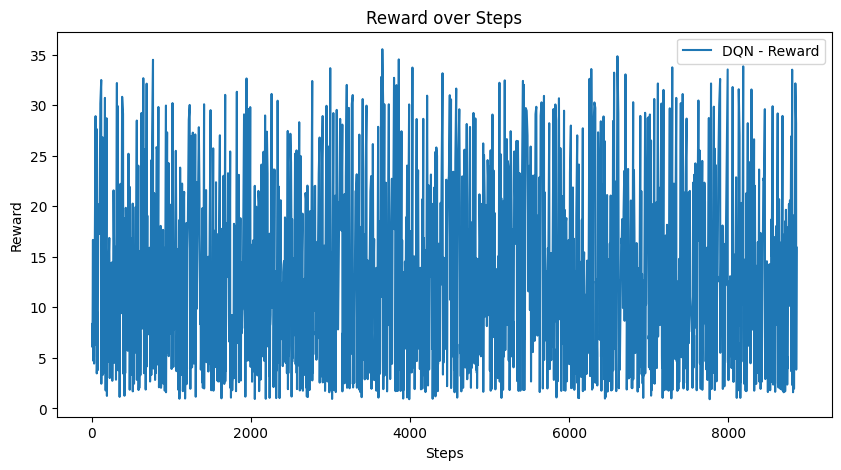

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(results_dqn['t'], results_dqn['r'], label='DQN - Reward')
plt.title('Reward over Steps')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.show()

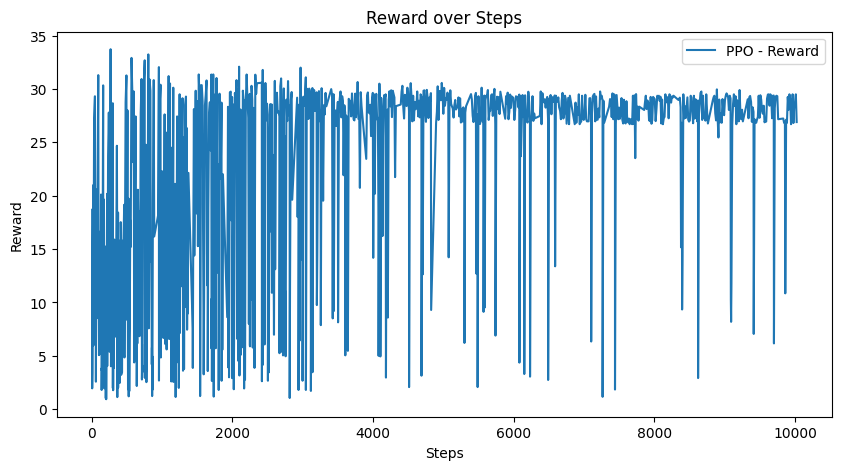

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(results_ppo['t'], results_ppo['r'], label='PPO - Reward')
plt.title('Reward over Steps')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.show()

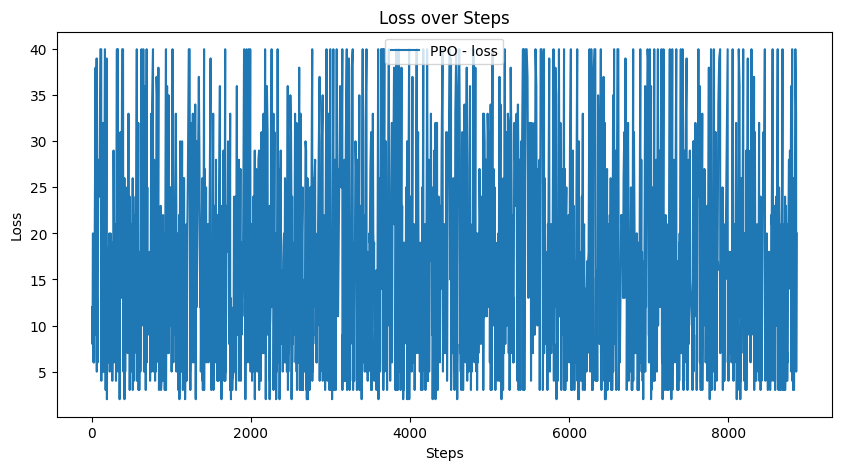

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(results_dqn['t'], results_dqn['l'], label='PPO - loss')
plt.title('Loss over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

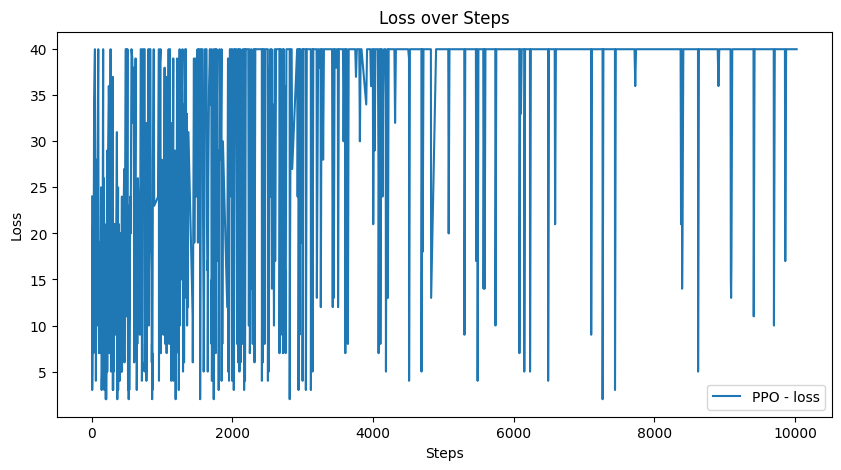

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(results_ppo['t'], results_ppo['l'], label='PPO - loss')
plt.title('Loss over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 7. Visualisierung der Modelle (Video)
#### a) DQN
##### Laden der Modelle

In [13]:
list_of_dqn_model: list = load_models_from_dir(
    path=MODELS_DQN_PATH,
    model_type='dqn',
)
list_of_dqn_model

In [59]:
vec_env = DummyVecEnv([lambda: gym.make(ENVIRONMENT_NAME, render_mode=ENVIRONMENT_RENDER_MODE)])
vec_env

/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


In [62]:
vec_video_recorder = VecVideoRecorder(
    venv=vec_env,
    video_folder="test/",
    record_video_trigger=lambda x: x == 0,
    video_length=200,
    name_prefix="dqn_model"
)

In [68]:
obs = vec_video_recorder.reset()
done = False
while not done:
    action, _states = list_of_dqn_model[0].predict(obs)
    obs, rewards, dones, info = vec_video_recorder.step(action)
    vec_env.render()
vec_video_recorder.close()

Moviepy - Building video /mnt/d/Projects/Hand-on-Reinforced-Learning/notebooks/test/dqn_model-step-103-to-step-303.mp4.
Moviepy - Writing video /mnt/d/Projects/Hand-on-Reinforced-Learning/notebooks/test/dqn_model-step-103-to-step-303.mp4


Moviepy - Done !
Moviepy - video ready /mnt/d/Projects/Hand-on-Reinforced-Learning/notebooks/test/dqn_model-step-103-to-step-303.mp4


/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:182: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
Exception ignored in: <function VecVideoRecorder.__del__ at 0x7ff0e4967be0>
Traceback (most recent call last):
  File "/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_video_recorder.py", line 113, in __del__
    self.close_video_recorder()
  File "/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_video_recorder.py", line 103, in close_video_recorder
    if self.recording:
  File "/home/tkister/miniconda3/envs/Hand-on-Reinforced-Learning/lib/python3.10/site-packages/stable_baselines3/common/vec_env/base_vec_env.py", line 392, in __getattr__
    return self.getattr_recurs

AttributeError: 'NoneType' object has no attribute 'get_image'